# Philadelphia Real Estate Price Estimator - Build Model


This notebook fetches the latest Philadelpha Property and Real Estate Transfer datasets, cleans up the data, and creates the machine learning model that can be used to estimate real estate sales prices.

To use, click the "Run" button above.

**The script will take some to execute. On my computer, with a very vast internet connection, this notebook takes about 38 minutes to run completely.**

Once the script has completed, it will save a machine learning model so that it can be used frequently without re-training.  To use the model, open the accompanying script "predict-price.ipynb".

[Click here to open the prediction notebook directly.](./predict-price.ipynb)



The input data is downloaded directly from the source web wites:

rtt_summary data comes from: https://data.phila.gov/visualizations/real-estate-transfers

pa_properties_publick comes from: https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump


## Load Data

Load the real estate transfers data.

**This is a large file and will take some time to load. Loading took just over 9 minutes on my fast fiber internet connection.**

In [2]:
%%time
transfers = pd.read_csv(
    'https://opendata-downloads.s3.amazonaws.com/rtt_summary.csv', 
    usecols=['document_type', 'street_address', 'total_consideration', 'document_date'],
    dtype={
        'document_type': 'string',
        'total_consideration': 'Float64',
        'document_date': 'string',
        'street_address': 'string',
    }
)


CPU times: user 12.1 s, sys: 5.6 s, total: 17.7 s
Wall time: 9min 17s


Load the property data.

**This file is smaller than the transfers, but still quite large.  It took about 2 minutes on my machine.**

In [6]:
%%time
properties = pd.read_csv(
    'https://opendata-downloads.s3.amazonaws.com/opa_properties_public.csv', 
    usecols=[
        'category_code', 'census_tract', 'central_air', 'depth', 'exterior_condition',
        'fireplaces', 'frontage', 'garage_spaces', 'number_of_bathrooms', 'number_of_bedrooms', 
        'number_of_rooms', 'number_stories', 'quality_grade', 'quality_grade', 'year_built', 
        'zip_code', 'total_area', 'total_livable_area', 'location', 'interior_condition'
    ],
    dtype={
        'category_code': 'Int32',
        'census_tract': 'string',
        'central_air': 'string',
        'depth': 'Float32',
        'exterior_condition': 'string',
        'fireplaces': 'Int32',
        'frontage': 'Float32',
        'garage_spaces': 'Int32',
        'interior_condition': 'string',
        'number_of_bathrooms': 'Int32',
        'number_of_bedrooms': 'Int32',
        'number_of_rooms': 'Int32',
        'number_stories': 'Int32',
        'quality_grade': 'string',
        'total_area': 'Float32',
        'total_livable_area': 'Float32',
        'year_built': 'string',
        'zip_code': 'string',
        'location': 'string',
    }
)

CPU times: user 4.03 s, sys: 1.13 s, total: 5.16 s
Wall time: 1min 51s


### Categeory Code 1 is residential

In [7]:
properties = properties[properties['category_code'] == 1]
properties.shape

(463643, 19)

### Fix small data inconsistencies

In [8]:
properties['central_air'] = properties['central_air'].map({'Y': 1, '1':1, 'N': 0, '0':0})
properties['central_air'] = properties['central_air'].fillna(0)
properties['central_air'].unique()
properties['garage_spaces'] = properties['garage_spaces'].fillna(0)
properties['exterior_condition'] = properties['exterior_condition'].fillna('0')
properties['interior_condition'] = properties['interior_condition'].fillna('0')
properties['fireplaces']= properties['fireplaces'].fillna(0)
properties['number_of_bathrooms'] = properties['number_of_bathrooms'].fillna(1)
properties['number_of_bedrooms'] = properties['number_of_bedrooms'].fillna(1)
properties['number_stories'] = properties['number_stories'].fillna(1)
properties['quality_grade'] = properties['quality_grade'].fillna('3 ')
properties['quality_grade'] = properties['quality_grade'].map({
    '7 ': 7, 
    'A+': 7,
    'S-': 6,
    'S+': 6,
    'X+': 6, 
    '6 ': 6, 
    'A ': 6, 
    'A-': 5, 
    'X ': 5,
    'X-': 5,
    'S ': 5, 
    '5 ': 5,
    'B+': 5, 
    'B ': 4, 
    'B-': 4,
    '4 ': 4, 
    '3 ': 3, 
    'C+': 3, 
    'C ': 3, 
    'C-': 2, 
    'D+': 2, 
    '2 ': 2, 
    'D ': 1, 
    'D-': 1, 
    '1 ': 1, 
    'E+': 1, 
    'E ': 1, 
    'E-': 0,
    '0 ': 0, 
})

### Only Deed transfers with a reasonble sales value are interesting.

Sometimes deed transfers have \\$0 or \\$1 consideration.  These aren't real sales.

In [9]:
transfers = transfers[(transfers['document_type'] == 'DEED') & (transfers['total_consideration'] > 1.0) ]

### About 3500 rows have invalid dates

The sale price doesn't mean much without a valid date, so we must discard that data.

In [10]:
transfers['document_date'] = pd.to_datetime(transfers['document_date'].str.split().str[0], format='%Y-%m-%d', errors='coerce')#transfers['document_date'] = pd.to_datetime(transfers['document_date'].str.split().str[0], format='%Y-%m-%d', errors='coerce')
transfers['transfer_year'] = transfers['document_date'].dt.year

### Age is a potential factor in the sales price.

Calculate the age so that it's available for regression and machine learning.

Unlike the document date, we can still learn something from the sale even if the building age is unknown.  We assume that buildings with unknown build dates are "old", and choose 1700 as a sufficiently old date.

In [11]:
properties['year_built_dt'] = pd.to_datetime(properties['year_built'], format='%Y', errors='coerce')
properties = properties.fillna(value={'year_built_dt':datetime.datetime(1700,1,1)})

### We need to distinguish between empty lots and built properties

The empty lots might help us to figure out the value of the property vs the value of the house that's built on it.

In [12]:
properties['empty_lot'] = properties['total_livable_area'].isna() | (properties['total_area'] < 100) | (properties['total_livable_area'] < 100)
properties = properties.fillna({'empty_lot': False})

## Join the tables

In [14]:
%%time
joined_transfers = pd.merge(
    transfers,
    properties,
    how="inner",
    left_on=['street_address'],
    right_on=['location'],
    sort=True
)

CPU times: user 1.9 s, sys: 12.6 ms, total: 1.91 s
Wall time: 1.92 s


In [15]:
joined_transfers['age'] = joined_transfers['transfer_year'] - joined_transfers['year_built_dt'].dt.year

### Eliminate negative age buildings

This appears to mean that the property was sold, torn down, rebuilt, and sold again.  We're eliminating the first sale because we don't have historical information about the attributes of this property at that time.

In [16]:
joined_transfers = joined_transfers[joined_transfers['age'] > 0]

## Calculate some statistics once for all rows


In [17]:
joined_transfers['price_per_total_area'] = joined_transfers.apply(lambda row: np.NaN if row['empty_lot'] else row['total_consideration'] / row['total_area'], axis=1)

In [18]:
joined_transfers['price_per_total_livable_area'] = joined_transfers.apply(lambda row: np.NaN if row['empty_lot'] else row['total_consideration'] / row['total_livable_area'], axis=1)

In [19]:
joined_transfers['price_per_lot_area'] = joined_transfers['total_consideration'] / joined_transfers['total_area']

In [20]:
joined_transfers['price_per_bedroom'] = joined_transfers.apply(lambda row: np.NaN if pd.isna(row['number_of_bedrooms']) or (row['number_of_bedrooms'] < 1) else row['total_consideration'] / row['number_of_bedrooms'], axis=1)

In [21]:
joined_transfers['price_per_bathroom'] = joined_transfers.apply(lambda row: np.NaN if pd.isna(row['number_of_bathrooms']) or (row['number_of_bathrooms'] < 1) else row['total_consideration'] / row['number_of_bathrooms'], axis=1)

# Price per square foot/bedroom/bathroom per year



In [22]:
price_per_area = joined_transfers[[
    'transfer_year',
    'price_per_total_area', 
    'price_per_total_livable_area',
    'price_per_bedroom',
    'price_per_bathroom',
]].groupby('transfer_year').mean()
price_per_area = price_per_area.reset_index()

# Visualizations

In [23]:
plt.style.use('seaborn-v0_8-pastel')

<Axes: >

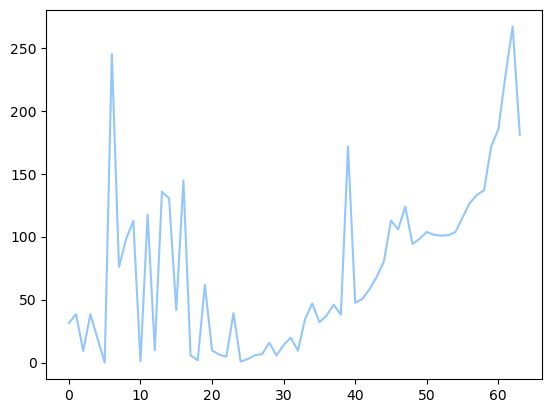

In [24]:
price_per_area['price_per_total_livable_area'].plot()

[]

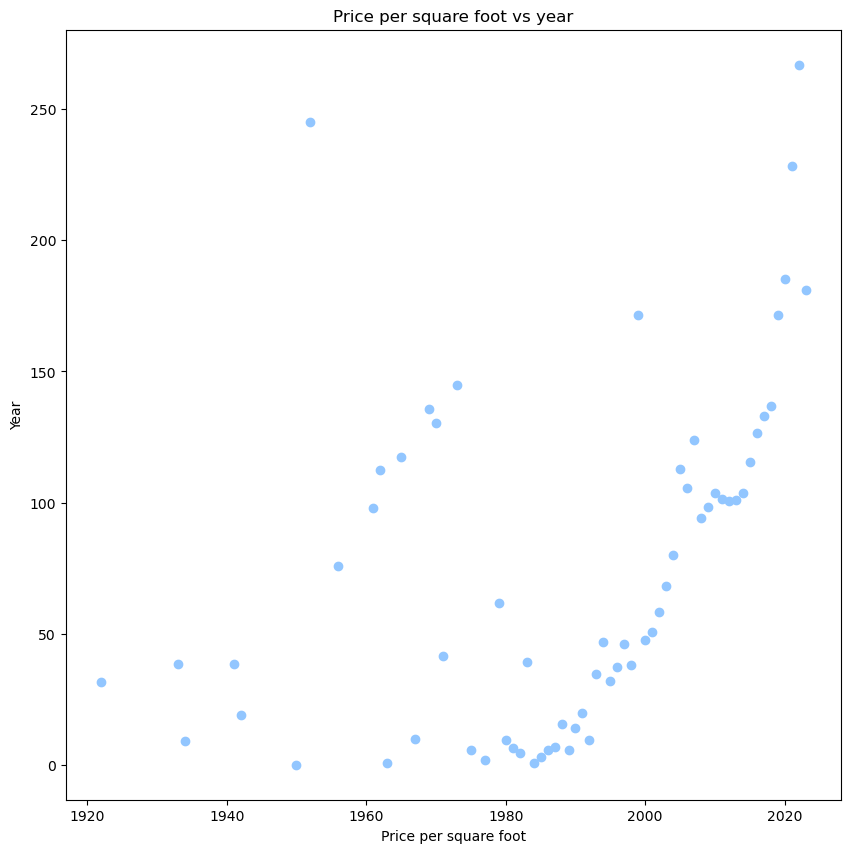

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Price per square foot vs year',
      xlabel = 'Price per square foot',
      ylabel = 'Year')
ax.scatter(price_per_area['transfer_year'], price_per_area['price_per_total_livable_area'])
ax.plot()


In [26]:
def fit(x, a, b, c):
    return a * np.exp(-b * (x-1984) + c)

In [27]:
after_1985 =  price_per_area[price_per_area['transfer_year']>=1985]

In [28]:
popt, pcov = scipy.optimize.curve_fit(fit,  after_1985['transfer_year'], after_1985['price_per_total_livable_area'])

/home/ami/projects/ml/philly-real-estate-estimator/env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


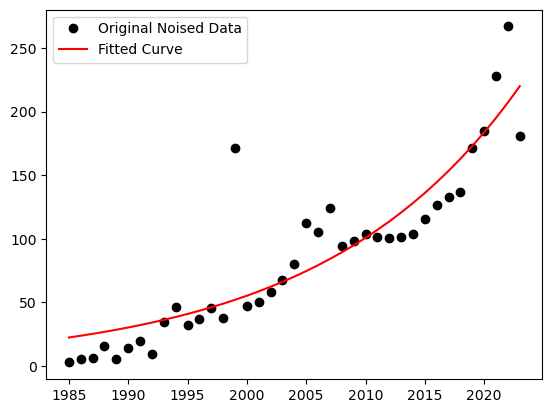

In [29]:
plt.figure()
plt.plot( after_1985['transfer_year'], after_1985['price_per_total_livable_area'], 'ko', label="Original Noised Data")
plt.plot( after_1985['transfer_year'], fit( after_1985['transfer_year'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

## Price per bedroom


<Axes: >

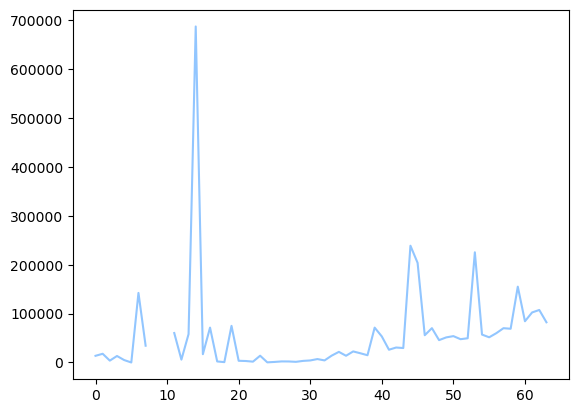

In [30]:
price_per_area['price_per_bedroom'].plot()

## Price per bathroom

<Axes: >

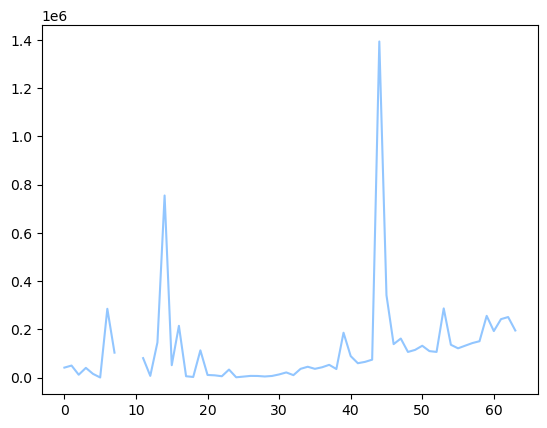

In [31]:
price_per_area['price_per_bathroom'].plot()

## See how price varies with number of bedrooms in a single year

In [32]:
price_by_bedrooms = joined_transfers[joined_transfers['transfer_year']==2022][['number_of_bedrooms','total_consideration']].groupby('number_of_bedrooms').mean()
price_by_bedrooms = price_by_bedrooms.reset_index()
price_by_bathrooms = joined_transfers[joined_transfers['transfer_year']==2022][['number_of_bathrooms','total_consideration']].groupby('number_of_bathrooms').mean()
price_by_bathrooms = price_by_bathrooms.reset_index()


<Axes: >

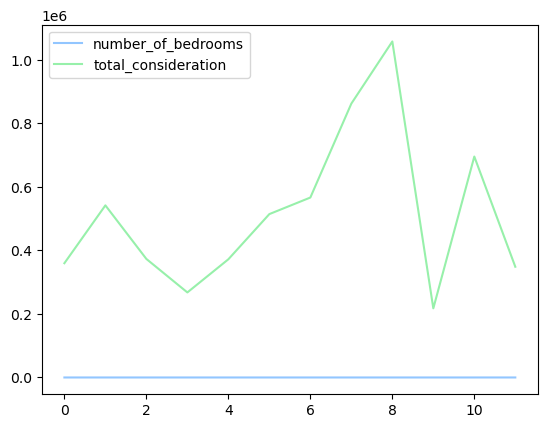

In [33]:
price_by_bedrooms.plot()

<BarContainer object of 12 artists>

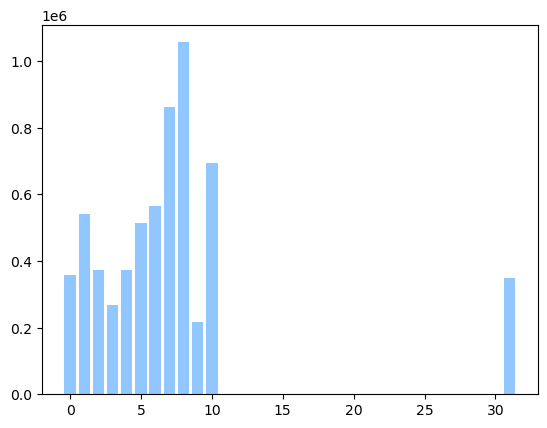

In [34]:
fig, ax = plt.subplots()
ax.bar(price_by_bedrooms['number_of_bedrooms'], price_by_bedrooms['total_consideration'])

<Axes: >

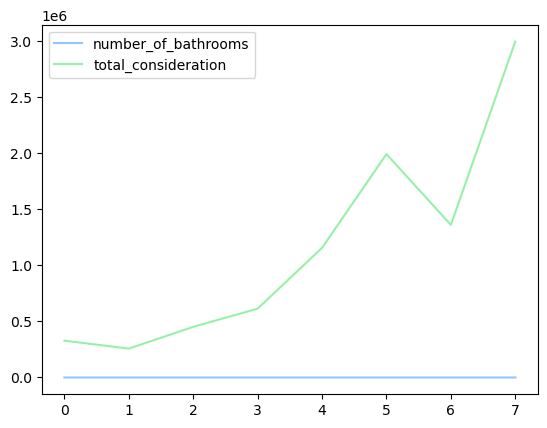

In [35]:
price_by_bathrooms.plot()

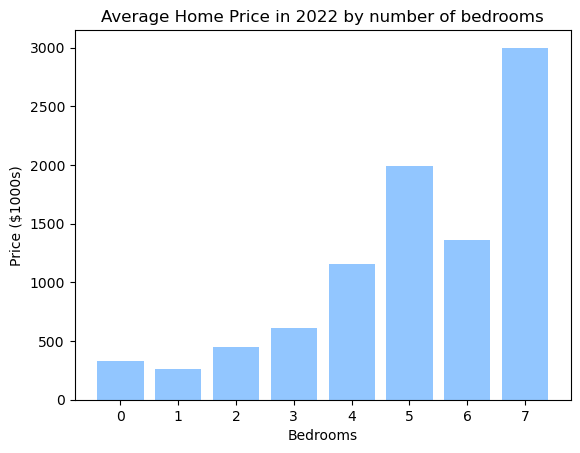

In [36]:
fig, ax = plt.subplots()
ax.set(
    title="Average Home Price in 2022 by number of bedrooms",
    ylabel="Price ($1000s)",
    xlabel="Bedrooms"
)
ax.bar(price_by_bathrooms['number_of_bathrooms'], price_by_bathrooms['total_consideration']/1000);


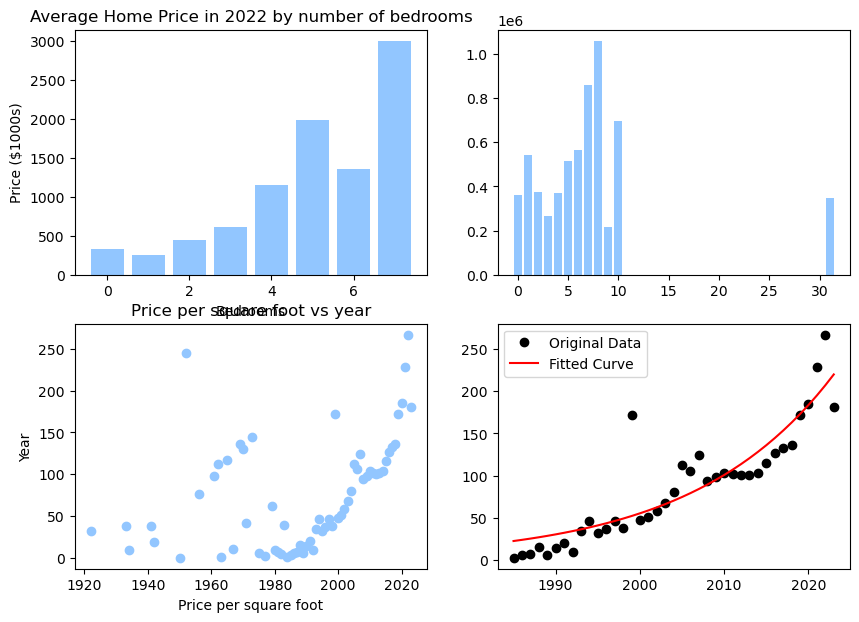

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

ax1.set(
    title="Average Home Price in 2022 by number of bedrooms",
    ylabel="Price ($1000s)",
    xlabel="Bedrooms"
)
ax1.bar(price_by_bathrooms['number_of_bathrooms'], price_by_bathrooms['total_consideration']/1000);

ax2.bar(price_by_bedrooms['number_of_bedrooms'], price_by_bedrooms['total_consideration'])

ax3.set(title='Price per square foot vs year',
      xlabel = 'Price per square foot',
      ylabel = 'Year')
ax3.scatter(price_per_area['transfer_year'], price_per_area['price_per_total_livable_area'])

ax4.plot( after_1985['transfer_year'], after_1985['price_per_total_livable_area'], 'ko', label="Original Data")
ax4.plot( after_1985['transfer_year'], fit( after_1985['transfer_year'], *popt), 'r-', label="Fitted Curve")
ax4.legend()


# Machine Learning


In [38]:
ml_x = joined_transfers[[
    'census_tract', 
    'transfer_year',
    'central_air',
    'depth',
    'exterior_condition',
    'fireplaces',
    'frontage',
    'garage_spaces',
    'interior_condition',
    'number_of_bathrooms',
    'number_of_bedrooms',
    'number_stories',
    'quality_grade',
    'total_area',
    'total_livable_area',
    'age',
    'zip_code'
]]
ml_y = joined_transfers[['total_consideration']]

In [39]:
ml_x = ml_x.fillna(value={
    'census_tract': '-',
    'depth': 0,
    'frontage': 0,
    'total_area': 0,
    'total_livable_area': 0, 
    'zip_code': '00000',
})

In [40]:
categorical_features = ['census_tract', 'central_air', 'exterior_condition', 'interior_condition', 'quality_grade', 'zip_code', 'number_stories']
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

transformed_X = transformer.fit_transform(ml_x)

In [41]:
np.random.seed(1205)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, ml_y)

**This step takes about 24 minutes on my computer.**

In [42]:
%%time
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test)

CPU times: user 23min 30s, sys: 1.01 s, total: 23min 31s
Wall time: 23min 31s


0.9763052894124338

In [43]:
dump(model, filename="real-estate-random-forest-100.joblib")

['real-estate-random-forest-100.joblib']

In [44]:
dump(transformer, filename="real-estate-transformer.joblib")

['real-estate-transformer.joblib']

## Proceed to the predict-price Notebook to use the model

The model was saved in the steps above.  Now you can proceed to the prediction notebook in order to use the model.

[Click here to open the prediction notebook directly.](./predict-price.ipynb)